In [1]:
import networkx as nx
import dgl
import torch
import matplotlib.pyplot as plt

Using backend: pytorch


In [2]:
import torch as th
import numpy as np
import scipy.sparse as spp

# Create the same graph from a list of integer pairs.
edge_list = [(0, 1),(1, 2),(2, 3),(2,6), (3, 4),(4, 5),(6, 7),(7, 8),(8, 6),(8, 9)]
graph_skelton = dgl.DGLGraph(edge_list)

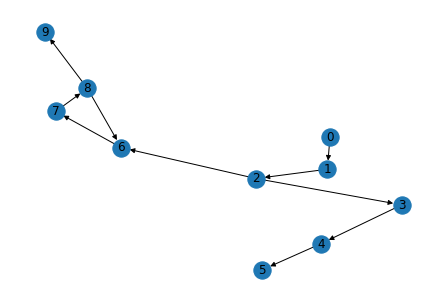

In [3]:
# Visualize the graph.
#graph_skelton.add_edges([9, 0])
nx.draw(graph_skelton.to_networkx(), with_labels=True)
plt.show()

In [4]:
# I assigned weights as transaction amount between two traders
x = th.tensor([10.0,20.0,40.0,20.0,50.0,80.0,70.0,10.0,40.0,20.0])
graph_skelton.edata['edge_weights'] = x

In [5]:
#assigning mp value for each account for easy graph traversal
y = th.tensor([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0])
graph_skelton.ndata['mp_value'] = y

In [6]:
# security balance
account_balance = th.tensor([20.0,100.0, 30.0,60.0,10.0,50.0,30.0,70.0,10.0,30.0])
graph_skelton.ndata['balance'] = account_balance

In [7]:
#graph_skelton.edata['edge_weights'][graph_skelton.edge_id(8, 6)]

In [8]:
#graph_skelton.edata['edge_weights'][graph_skelton.edge_id(1,2)]

### reverse the graph 

In [9]:
#reversing the graph for easy message passing work
rg =graph_skelton.reverse(share_ndata=True, share_edata=True)

In [10]:
#rg.edata['edge_weights'][rg.edge_id(1, 0)] = 555

In [11]:
#graph_skelton= rg.reverse(share_ndata=True, share_edata=True)

In [12]:
#graph_skelton.edata['edge_weights']

### message passing functions

In [13]:
def pagerank_message_func(edges):
    return {'sumof_edge_weights_mpvalue' : edges.data['edge_weights'] + edges.src['mp_value']}

In [14]:
DAMP = 1  # damping factor
def pagerank_reduce_func(nodes):
    msgs = torch.sum(nodes.mailbox['sumof_edge_weights_mpvalue'], dim=1)
    mp_value = DAMP * msgs
    return {'mp_value' : mp_value}

In [15]:
# register the above message and reduce function to the reversed graph
rg.register_message_func(pagerank_message_func)
rg.register_reduce_func(pagerank_reduce_func)

In [16]:
# Iterate k times of message passing
K=10
for k in range(K):
    rg.send(rg.edges())
    rg.recv(rg.nodes())
    print(rg.ndata['mp_value'])

tensor([10., 20., 60., 50., 80.,  0., 70., 10., 60.,  0.])
tensor([ 30.,  80., 180., 130.,  80.,   0.,  80.,  70., 130.,   0.])
tensor([ 90., 200., 270., 130.,  80.,   0., 140., 140., 140.,   0.])
tensor([210., 290., 330., 130.,  80.,   0., 210., 150., 200.,   0.])
tensor([300., 350., 400., 130.,  80.,   0., 220., 210., 270.,   0.])
tensor([360., 420., 410., 130.,  80.,   0., 280., 280., 280.,   0.])
tensor([430., 430., 470., 130.,  80.,   0., 350., 290., 340.,   0.])
tensor([440., 490., 540., 130.,  80.,   0., 360., 350., 410.,   0.])
tensor([500., 560., 550., 130.,  80.,   0., 420., 420., 420.,   0.])
tensor([570., 570., 610., 130.,  80.,   0., 490., 430., 480.,   0.])


..\torch\csrc\utils\python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


In [17]:
graph_skelton= rg.reverse(share_ndata=True, share_edata=True)

In [18]:
graph_skelton.ndata['mp_value']

tensor([570., 570., 610., 130.,  80.,   0., 490., 430., 480.,   0.])

### traversing through the graph to find the optimum path

In [19]:
#graph_skelton.nodes( max(graph_skelton.ndata['pv']) )

In [20]:
src, dst, eid = graph_skelton.out_edges(2,'all')

In [21]:
# final transaction history between security accounts

source_nodes=[]
destination_nodes=[]
Amount_list=[]

In [22]:
# check the other available nodes from current node

def next_possible_nodes(graph, current_node):
    src, dst, eid = graph.out_edges(current_node,'all')
    if len(dst) !=0:
        dst.sort()
        possible_nodes= dst.tolist()
    else:
        possible_nodes=[]
    
    return possible_nodes


In [23]:
next_possible_nodes(graph_skelton,2)

[3, 6]

In [24]:
#transaction between two accounts

def transaction(graph, src, dst, amount):
    source_nodes.append(src)
    destination_nodes.append(dst)
    Amount_list.append(amount)
    
    graph.nodes[src].data['balance'] = graph.nodes[src].data['balance'] - amount
    graph.nodes[dst].data['balance'] = graph.nodes[dst].data['balance'] + amount
    graph.remove_edges([graph.edge_id(src,dst)])
    

In [25]:
# node_path=[]

# def choose_next_node(graph, current_node):
#     src, dst, eid = graph.out_edges(current_node,'all')
#     max_val=0
#     for dst_node in dst:
#         print(graph.nodes[dst_node].data['pv'])
#         if graph.nodes[dst_node].data['pv'] > max_val:
#             max_val = graph.nodes[dst_node].data['pv']
#             max_node = dst_node

#     node_path.append(max_node)

# choose_next_node(graph_skelton,2)

In [26]:
## change the praph_skelton from get_pv() method
def get_pv(e):
    return graph_skelton.nodes[e].data['mp_value']


In [27]:
## a graph walk using a recursive function
## walk from a given node through possible nodes
def graph_walk(graph, current_node):
    
    n_p_nodes = next_possible_nodes(graph, current_node)
    
    if n_p_nodes:
        n_p_nodes.sort(reverse=True, key= get_pv)
        
        for next_node in n_p_nodes:
                   
            amount = graph.edata['edge_weights'][graph.edge_id(current_node, next_node)]
            if graph.nodes[current_node].data['balance'] >= amount:
                print('from node ' , current_node , ' to ' , next_node , ' | amount = ', amount)
                transaction(graph, current_node, next_node, amount)
                graph_walk(graph,next_node)
            
            elif graph.nodes[current_node].data['balance'] >0:
                print('from node ' , current_node , ' to ' , next_node , ' | amount = ', graph.nodes[current_node].data['balance'][0])
                transaction(graph, current_node, next_node, graph.nodes[current_node].data['balance'][0])
                graph_walk(graph,next_node)
    


In [28]:
# finding out-degree vertices with high mp_value

def find_out_degree_nodes(graph_skelton):
    out_degree_nodes= graph_skelton.edges()[0]
    out_degree_nodes= out_degree_nodes.tolist()
    out_degree_nodes= list(set(out_degree_nodes))
    out_degree_nodes.sort(reverse=True, key= get_pv)
    return out_degree_nodes


In [29]:
# state=True
# while state:
#     out_degree_nodes= find_out_degree_nodes(graph_skelton)
#     graph_walk(graph_skelton, out_degree_nodes[0])
#     if out_degree_nodes == find_out_degree_nodes(graph_skelton):
#         state = False


In [31]:
## A walk through entire graph by selecting a siutable starting node.

out_degree_nodes = find_out_degree_nodes(graph_skelton)
out_degrees_without_balance_zero = [x for x in out_degree_nodes if graph_skelton.nodes[x].data['balance']>0 ]
while len(out_degrees_without_balance_zero) !=0:
    graph_walk(graph_skelton, out_degrees_without_balance_zero[0])
    out_degree_nodes= find_out_degree_nodes(graph_skelton)
    out_degrees_without_balance_zero = [x for x in out_degree_nodes if graph_skelton.nodes[x].data['balance']>0 ]


from node  0  to  1  | amount =  tensor(10.)
from node  1  to  2  | amount =  tensor(20.)
from node  2  to  6  | amount =  tensor(20.)
from node  6  to  7  | amount =  tensor(50.)
from node  7  to  8  | amount =  tensor(10.)
from node  8  to  6  | amount =  tensor(20.)
from node  3  to  4  | amount =  tensor(50.)
from node  4  to  5  | amount =  tensor(60.)


In [32]:
len(out_degrees_without_balance_zero)

0

In [29]:
#graph_skelton.edata['edge_weights'][graph_skelton.edge_id(6, 7)]

In [39]:
# transaction from
source_nodes

[0, 1, 2, 6, 7, 8, 2, 3, 4]

In [33]:
# transation to
destination_nodes

[1, 2, 6, 7, 8, 6, 3, 4, 5]

In [34]:
# transaction amount
Amount_list

[tensor(10.),
 tensor(20.),
 tensor(20.),
 tensor(50.),
 tensor(10.),
 tensor(20.),
 tensor(40.),
 tensor(50.),
 tensor(60.)]

In [35]:
#th.tensor([20.0,100.0,90.0,40.0,10.0,50.0,30.0,70.0,10.0,30.0])
graph_skelton.nodes[8].data['balance']

tensor([0.])

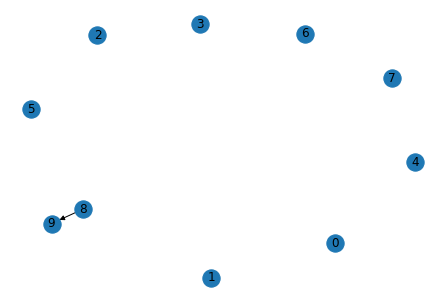

In [36]:
nx.draw(graph_skelton.to_networkx(), with_labels=True)
plt.show()